In [1]:
from stringprep import b1_set

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('data/names.txt', 'r') as f:
    words = f.read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)

In [4]:
block_size = 3 # context length

def build_dataset(words):
    # build the dataset
    X, Y = [], []
    for w in words:
        # print(w)
        # Лист болванка из 0 для дальнейшего заполнения
        context = [0] * block_size
        # print(context)
        for ch in w + '.':
            # Индекс символа в словаре
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '------>', itos[ix])
            # Убрали первый символ, добавили новый
            context = context[1:] + [ix] # crop and append
            # print(context)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [5]:
import random

# Начало случайного распределения зафиксировано, дальше все что будет генерироваться при перезапуске программы будет одинаковым. Если вызывать несколько раз внутри одной и той же программы, результаты будут разными
random.seed(42)

In [6]:
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Определение класса слоя

In [7]:
# Аналог LinerLayer из pytorch, за исключением девайса на котором считать и dtype
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        """
        :param fan_in: кол-во инпутов
        :param fan_out: кол-во аутпутов
        :param bias: нужен ли bias
        """
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

# Тяжелый ли для рассчета это слой?
# Используетя ли сейчас он, или какие-то более современные аналоги?
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        # Разделяем поведение на training mode и evaluation mode
        self.training = True

        # Параметры тренируемые в BatchNorm
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Обновляемые в ходе расчета скользящие значения параметров
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        # Во время тренировки используем среднее и отклонение из текущего батча
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.std(0, keepdim=True, unbiased=True) # batch var
        # Во время теста используем скользящие значения среднего и отклонения
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # BN трансформация
        self.out = self.gamma * xhat + self.beta

        # Обновление скользящих значений параметров (buffers), не тренируются
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [8]:
# Фиксирую seed для воспроизводимости
torch.manual_seed(42)

In [9]:
n_emb = 10
n_hidden = 200

C = torch.randn((vocab_size, n_emb))

layers = [
    Linear(n_emb * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # Уменьшение уверенности последнего слоя
    layers[-1].weights *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("N of parameters: {}".format(sum(p.nelement() for p in parameters)))
for p in parameters:
    p.requires_grad = True

N of parameters: 12097


Optimization loop

      0/ 100000: 3.3034
  10000/ 100000: 2.2465
  20000/ 100000: 2.1340
  30000/ 100000: 2.1582
  40000/ 100000: 2.1422
  50000/ 100000: 2.1109
  60000/ 100000: 1.9946
  70000/ 100000: 2.0494
  80000/ 100000: 2.1786
  90000/ 100000: 2.0211


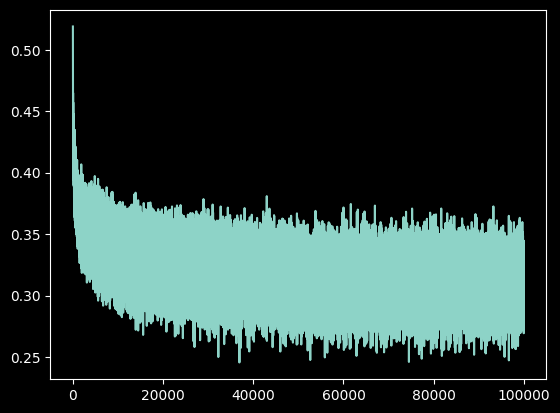

In [10]:
max_steps = 100_000
batch_size = 256
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]

    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 50000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i == 1000:
    #     break

plt.plot(lossi)

In [11]:
# Для того чтобы сделать eval при BatchNorm
for layer in layers:
    layer.training = False

In [12]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.034884452819824
val 2.097590684890747


In [13]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

hadir.
chylah.
yazeen.
jolimi.
shyana.
andalyen.
nylah.
emmarjaire.
lyn.
jaysyn.
amercelerael.
aniel.
aylee.
luni.
hanasp.
ale.
ayro.
arthevan.
siyahramaeli.
ross.


### Сглаживаю функцию ошибки

In [14]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [15]:
torch.arange(10).view(2, 5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [16]:
torch.arange(10).view(5, 2)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [17]:
torch.arange(10).view(5, -1)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [18]:
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([100, 1000])

In [19]:
# Получается одна точка для среднего по 1000 итераций
torch.tensor(lossi).view(-1, 1000).mean(1).shape

torch.Size([100])

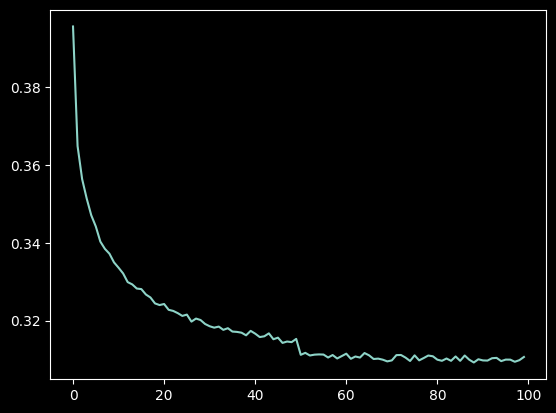

In [20]:
# Тут быстрое уменьшение ошибки в моменте эффект learning_rate_decay
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

### Добавляю модули embed и Flatten чтобы встроить их в общий пайплайн и уменьшить объем кода в оптимизации

In [24]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weights = torch.randn(num_embeddings, embedding_dim)

    def __call__(self, IX):
        # Провести кодировку
        return self.weights[IX]

    def parameters(self):
        return [self.weights]

class Flatten:
    def __call__(self, x):
        return x.view(x.shape[0], -1)

    def parameters(self):
        return []

### Добавляю container для слоев наподобие torch.sequential

In [40]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [54]:
n_emb = 10
n_hidden = 200

model = Sequential(
    [
    Embedding(vocab_size, n_emb),
    Flatten(),
    Linear(n_emb * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
    ]
)

with torch.no_grad():
    # Уменьшение уверенности последнего слоя
    layers[-1].weights *= 0.1

parameters = model.parameters()
print("N of parameters: {}".format(sum(p.nelement() for p in parameters)))
for p in parameters:
    p.requires_grad = True

N of parameters: 12097


      0/ 100000: 3.4740
  10000/ 100000: 2.0539
  20000/ 100000: 2.0176
  30000/ 100000: 2.1904
  40000/ 100000: 2.0502
  50000/ 100000: 2.1178
  60000/ 100000: 2.0900
  70000/ 100000: 1.9854
  80000/ 100000: 2.0010
  90000/ 100000: 2.1161


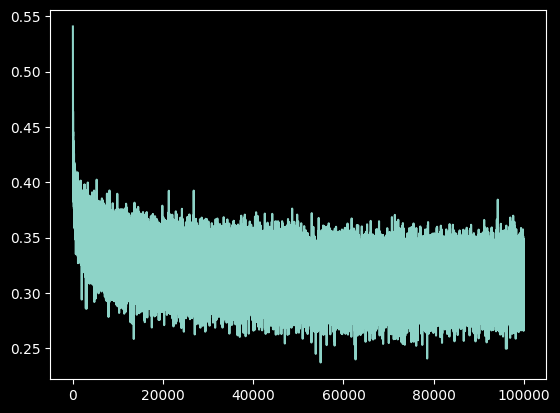

In [55]:
max_steps = 100_000
batch_size = 256
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 50000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

plt.plot(lossi)

In [56]:
for layer in model.layers:
    layer.training = False

In [57]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0374302864074707
val 2.0951786041259766


In [58]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

sia.
enley.
ante.
ismmalyssa.
qinaicabrion.
salea.
aari.
mila.
alaivindini.
jouriel.
sorterriella.
leanrellanon.
jerenciel.
games.
rehameriah.
xandriah.
monsera.
kella.
mckino.
cie.
